# **Load Tokenizer dan Model IndoBERT**

In [12]:
%pip install transformers scikit-learn tqdm

In [13]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

# **load dataset**

In [14]:
# Load data yang telah diproses
train_df = pd.read_csv('../data/split_data_full/train_dataset.csv')
val_df = pd.read_csv('../data/split_data_full/val_dataset.csv')
test_df = pd.read_csv('../data/split_data_full/test_dataset.csv')

In [15]:
# STEP 4: Load IndoBERT
model_name = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()  # tidak untuk fine-tuning

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [16]:
def get_bert_embeddings(texts, tokenizer, model, max_length=256, batch_size=16):
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(batch.tolist(), padding=True, truncation=True,
                                max_length=max_length, return_tensors="pt")
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.extend(cls_embeddings)
    return np.array(embeddings)


In [18]:
# start time
start_time = time.time()

# STEP 6: Proses Ekstraksi Embedding
X_train = get_bert_embeddings(train_df['stemming'], tokenizer, model)
X_val = get_bert_embeddings(val_df['stemming'], tokenizer, model)
X_test = get_bert_embeddings(test_df['stemming'], tokenizer, model)

# Catat waktu selesai
end_time = time.time()

# Hitung durasi pelatihan
training_duration = end_time - start_time

# Simpan embeddings ke file
np.save("../data/split_data_full/embeddings/X_train_full.npy", X_train)
np.save("../data/split_data_full/embeddings/X_val_full.npy", X_val)
np.save("../data/split_data_full/embeddings/X_test_full.npy", X_test)

# Format durasi menjadi jam:menit:detik
import datetime
formatted_duration = str(datetime.timedelta(seconds=int(training_duration)))
print(f"Durasi embeddings IndoBERT: {formatted_duration}")

100%|██████████| 212/212 [02:17<00:00,  1.54it/s]

Durasi embeddings IndoBERT: 0:11:39


In [ ]:
# mengambil label/target Y
Y_train = train_df['label_num']
Y_val = val_df['label_num']
Y_test = test_df['label_num']

In [ ]:
# Catat waktu mulai
start_time = time.time()

# Melatih model SVM
svm_model = LinearSVC(class_weight='balanced')
svm_model.fit(X_train, Y_train)

# Catat waktu selesai
end_time = time.time()

# Hitung durasi pelatihan
training_duration = end_time - start_time

# Format durasi menjadi jam:menit:detik
import datetime
formatted_duration = str(datetime.timedelta(seconds=int(training_duration)))
print(f"Durasi pelatihan SVM: {formatted_duration}")

Durasi pelatihan SVM: 0:00:21


In [ ]:
# Prediksi
pred_labels = svm_model.predict(X_test)

# Daftar label sesuai urutan label_num kamu (0=positif, 1=netral, 2=negatif)
target_names = ['positive', 'neutral', 'negative']

# Evaluasi
target_names = ['positive', 'neutral', 'negative']
print("\nEvaluasi Model SVM:")
print("Accuracy:", accuracy_score(Y_test, pred_labels))
print(classification_report(Y_test, pred_labels, target_names=target_names))


Evaluasi Model SVM:
Accuracy: 0.7770549970431697
              precision    recall  f1-score   support

    positive       0.42      0.65      0.51       229
     neutral       0.76      0.71      0.73      1182
    negative       0.85      0.83      0.84      1971

    accuracy                           0.78      3382
   macro avg       0.68      0.73      0.69      3382
weighted avg       0.79      0.78      0.78      3382



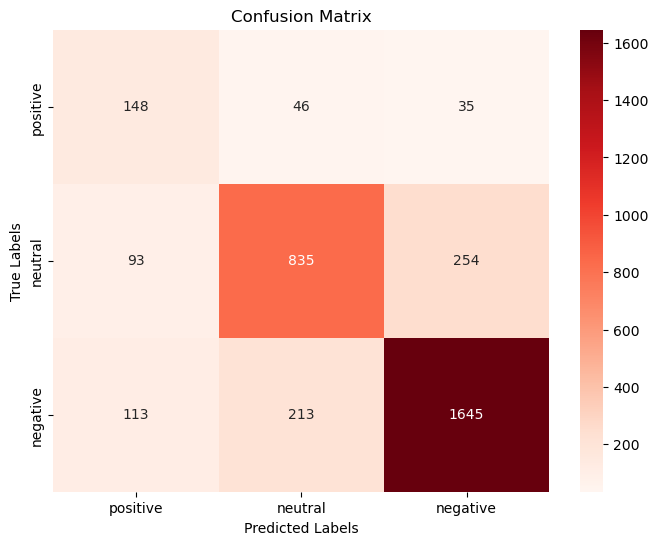

In [ ]:
# Buat confusion matrix
cm = confusion_matrix(Y_test, pred_labels)

# Daftar label sesuai urutan label_num (0=positif, 1=netral, 2=negatif)
target_names = ['positive', 'neutral', 'negative']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from joblib import dump

# Simpan model ke dalam folder ../models
os.makedirs("../models", exist_ok=True)
dump(svm_model, "../models/svm_model_full.joblib")
print("Model SVM disimpan di folder models/svm_model_full.joblib✅")

Model SVM disimpan di folder models/svm_model_full.joblib✅
